## Wrangle OpenStreetMap Data Project

### Map Area: Aurora, Colorado, USA

The map area I chose for this project was Aurora, Colorado.  I decided to use this area because I lived here for a good portion of the last decade and wanted to take a closer look at a dataset of an area that I knew pretty well.    

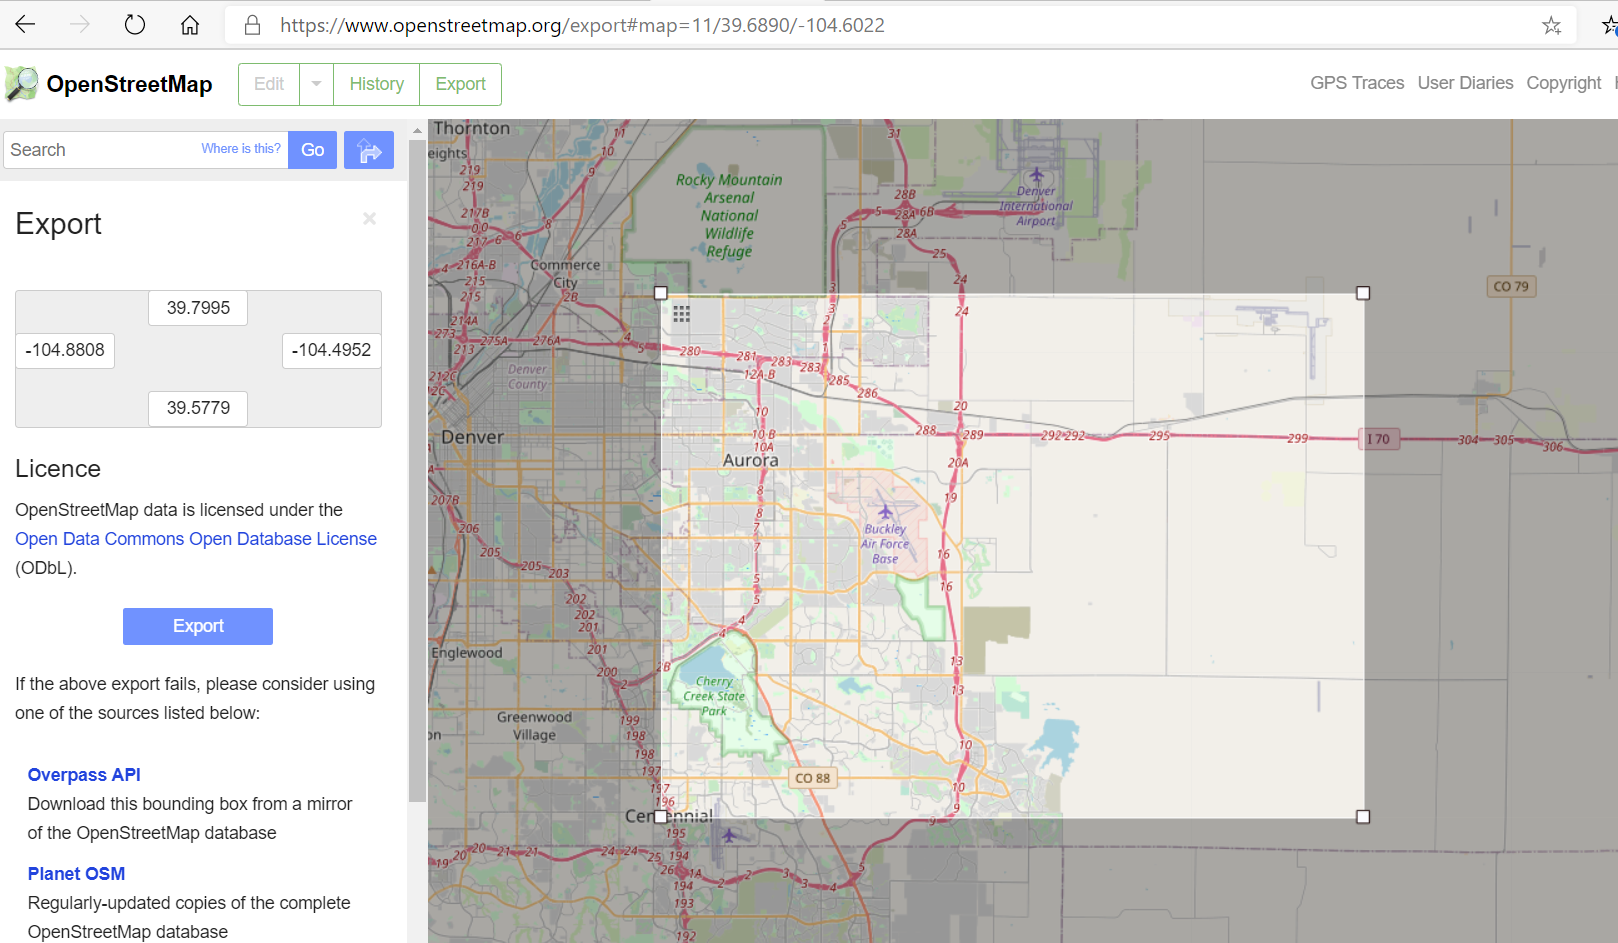

In [1]:
from IPython.display import Image
Image(filename="aurora.png")

Once my data had been exported, I moved into Python to start exploring.  I started by looking at the size of the file itself.  At 1.06 gb, this is too big to try to explore and fine tune code on, so I used the sampling code provided in the project steps, and modified it slightly to create two different osm files that could be used for my exploration and audting phases of this analysis. This code can be found in the Sample_osm.py file.  

In [18]:
import os
 
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size
 
file_path = "aurora.osm"
size = get_file_size(file_path)
print('File size: '+ str(round(size / (1024 * 1024), 3)) +' megabytes')
print('File size: '+ str(round(size / (1024 * 1024 * 1024), 3)) +' gigabytes')


File size: 1092.522 megabytes
File size: 1.067 gigabytes


Now I had three files, aurora.osm, sample.osm, and test.osm.  
These files will allow me to continue exploring the data without spending endless hours running code against such a large dataset.  


## Data Exploration:

I started my analysis by going through several fields that I had a better sense of what would be returned, such as City, State, Zip, and Street name.

### State:

In [21]:
import xml.etree.cElementTree as ET
from collections import defaultdict
osm_file = open("sample.osm", "r", encoding= 'utf-8')
def view(filename):
    file = (filename)
    data = defaultdict(set)


    for event, element in ET.iterparse(file, events=("start",)):
        if element.tag == "node":
            for tag in element.iter("tag"):
                if tag.attrib['k'] == "addr:state":
                    data[type].add(tag.attrib['v'])

    return dict(data)

print(view("sample.osm"))

{<class 'type'>: {'CO'}}


State was consistent across the dataset, all fields returning CO, the state was expected, but the format being consistent was a pleasant surprise.

### City:

In [22]:
import xml.etree.cElementTree as ET
from collections import defaultdict
osm_file = open("sample.osm", "r", encoding= 'utf-8')
def view(filename):
    file = (filename)
    data = defaultdict(set)


    for event, element in ET.iterparse(file, events=("start",)):
        if element.tag == "node":
            for tag in element.iter("tag"):
                if tag.attrib['k'] == "addr:city":
                    data[type].add(tag.attrib['v'])

    return dict(data)

print(view("sample.osm"))

{<class 'type'>: {'Parker', 'Lakewood', 'Lone Tree', 'Centennial', 'Edgewater', 'Arvada', 'Greenwood Village', 'Denver', 'Lakeside', 'Columbine', 'Littleton', 'Aurora', 'Twin Lakes'}}


The city field returned more results, a few more than expected, such as Twin Lakes, Lakewood, and Arvada.  All three are further west than I would have expected to see in this data, with the first being up in the mountains. 

### Zip:

In [3]:
import xml.etree.cElementTree as ET
from collections import defaultdict

def zip_codes(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:postcode":
                    count += 1
                    data.add( tag.attrib['v'] )

    return count, data

expectedzip =list(range(80000,80600))

expected=map(str, expectedzip)

def audit_zip_range(zip, wrong_zip, tag):
    if len(tag.attrib["v"]) == 5:
        if tag.attrib["v"] not in zip:
            zip[tag.attrib["v"]]=1
        else:
            zip[tag.attrib["v"]]+=1
    else:
        if tag.attrib["v"] not in wrong_zip:
            wrong_zip[tag.attrib["v"]]=1
        else:
            wrong_zip[tag.attrib["v"]]+=1

def is_zip(elem):
    return (elem.attrib['k'] == "addr:postcode")

def process_map_zips(filename):
    zip={}
    wrong_zip={}
    osm_file = open("sample.osm", "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_zip(tag):
                    audit_zip_range(zip, wrong_zip, tag)
    return zip, wrong_zip

print(process_map_zips("sample.osm"))


({'80016': 10, '80212': 84, '80205': 77, '80123': 8, '80210': 61, '80014': 23, '80237': 12, '80134': 7, '80220': 1, '80218': 41, '80012': 2, '80239': 118, '80010': 3, '80211': 136, '80111': 15, '80216': 20, '80203': 25, '80231': 14, '80204': 75, '80214': 4, '80221': 21, '80202': 16, '80017': 3, '80249': 2, '80247': 11, '80224': 4, '80120': 69, '80112': 6, '80128': 13, '80124': 1, '80003': 1, '80209': 58, '80222': 44, '80002': 1, '80121': 3, '80045': 1, '80031': 5, '80223': 37, '80113': 10, '80022': 2, '80620': 1, '80206': 56, '80229': 9, '80013': 3, '80129': 1, '80015': 1, '80207': 1, '80246': 1, '80219': 135, '80110': 8, '80226': 1, '80236': 28, '80227': 4, '80122': 1, '80640': 1, '80126': 1}, {'80246-2732': 1})


It looks like this zip code data is in pretty good shape, the only issue we have is one instance where the zip code also includes the 4 digit suffix.  To keep things uniform, we can change these zipcodes to make sure they only have 5 digits before going into the database.  I will run this code against test.osm to ensure there are no additional issues that need to be addressed.  

### Street Name:

In [31]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import xml.etree.cElementTree as ET

osm_file = open("sample.osm", "r", encoding= 'utf-8')

# Search for unexpected street types
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

# Expected street names
expected = ["Street", "Avenue", "Lane", "Way", "Boulevard",
"Drive", "Court", "Place", "Square", "Road", "Trail", "Parkway", "Commons", "North", "South", "West", "East"]


# Here we add any street name that isn't in our expected dictionary
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
    return street_types

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(filename):
    f = (filename)
    street_types = defaultdict(set)
    
    for event, element in ET.iterparse(f, events=("start",)):
        if element.tag == "node" or element.tag =="way":
            for tag in element.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])

    f.close()
    return dict(street_types)
print(audit(osm_file))


{'Mainstreet': {'East Mainstreet'}, 'Mall': {'16th Street Mall'}, 'Broadway': {'Broadway', 'South Broadway'}, 'Circle': {'West Long Circle', 'South Datura Circle', 'South Windermere Circle', 'East Cornell Circle', 'East Warren Circle', 'East Dartmouth Circle', 'Heritage Hills Circle', 'Ashbury Circle', 'South Sundown Circle', 'East Carolina Circle', 'East Carter Circle', 'East Lake Circle', 'West Delaware Circle', 'South Louthan Circle', 'South Spotswood Circle', 'South Ivory Circle', 'West Houstoun Waring Circle', 'East Applewood Circle', 'East 47th Avenue Circle', 'West Bryant Circle'}, 'Bypass': {'Wadsworth Bypass'}, '2': {'State Highway 2'}}


Here we see some of the additional street names we should expect to see such as cirlce, bypass, and interestingly, the number 2 for a particular state highway.  This code run against the test.osm file will provide my list of expected values for the final step of data transformation before it is saved as a json.  

## Problems Encountered: 
<ul>
<li>Non-5 digit zips</li>
<li>Unexpected street names</li>
</ul>

## Non-5 digit zip codes

In this dataset, there were a handful of zip codes that were not in my expected 5 digit format.  Due to this, I created the following simple function that checks the length of the zip code field, and returns the first 5 digits if it is longer.  This function will be called in my json mapping script to clean the zip code field before this data is added to the database.   

In [4]:
# return 5 digit zips
def clean_zip(zip):
    if len(zip)>5:
        new_zip=int(zip.strip()[:4])
    else:
        new_zip=int(zip.strip())
    return new_zip

## Unexpected street names

Through my exploration of street names, I found that there were numerous numbers, and other key terms that we should expect such as Circle, or Broadway that are legitimate street names/endings in Aurora.  I took these common names and created a mapping dictionary that will be used by the update_name function to match these variants, and transform them to their correct values before the data is added to the database.  

In [ ]:
mapping = { "E.": "East", "W.":"West", "N.": "North", "S.":"South","Rd": "Road",
            "Rd.": "Road", "ln": "Lane", "ln.": "Lane", "Ln": "Lane", "Ln.": "Lane", "Pl":"Place", "CO-7":"CO 7", "Ct": "Court", "dr": "Drive",
            "dr.": "Drive", "Dr": "Drive", "Dr.": "Drive", "st": "Street", "St": "Street", "St.": "Street", "Ste": "Suite",
            "Ste.": "Suite", "Trl": "Trail", "Cir": "Circle", "cir": "Circle", "CR": "Country Road", "Av": "Avenue", "Ave": "Avenue",
            "Ave.": "Avenue", "Hwy": "Highway", "Hwy.": "Highway", "HIghway": "Highway", "Pky": "Parkway", "Pky.": "Parkway",
            "Pkwy": "Parkway", "pkwy": "Parkway", "Fwy": "Freeway", "Fwy.": "Freeway", "BLVD": "Boulevard", "Blvd": "Boulevard",
            "Blvd.": "Boulevard", "Expy": "Expressway", "Expessway": "Expressway"}

def update_name(name, mapping):
    fixed = []
    # Split name string to test each part individually
    for word in name.split(" "):
        # remove extra chars and make lowercase
        word = word.strip(",_\.-").lower()
        # check against mapping keys
        if word in mapping.keys():
            # If key exists then overwrite with the dict value
            word = mapping[word]
        # Rejoin and capitalize
        fixed.append(word.capitalize())
    # Join words back together with a space
    return " ".join(fixed)


I compiled the code above into my attached CreateJson.py file to map the osm file to JSON, while changing the data en route then we are ready to create and explore the database.  

## MongoDB:

Below, I define few functions to get the db, get the db collections, and to insert the data into the database.  

In [12]:
from pymongo import MongoClient
import json
import pprint

# Get database:
def get_db(db_name):
    client = MongoClient("mongodb://localhost:27017")
    db = client[db_name]
    return db

## Get MongoDB collections
def get_collection(db, collection):
    collections_db = db[collection]
    return collections_db

## Insert data
def insert(json_data, db_collection):
    with open(json_data, 'r') as x:
        for line in x.readlines():
            db_collection.insert_one(json.loads(line))
    print("Done!")

DATA_json = "aurora.osm.json"


db = get_db('aurora')
db_aurora = get_collection(db, 'aurora')

## Queries:

In [13]:
print("Number of Documents: " + str(db.aurora.count_documents({})))

Number of Documents: 11111496


In [14]:
print("Number of Unique Users: " + str(len(db.aurora.distinct("created.user"))))

Number of uniques Users: 2078


In [16]:
print("Number of Nodes: " + str(db.aurora.count_documents({'type': "node"})))
print("Number of Ways: " + str(db.aurora.count_documents({'type': "way"})))

Number of Nodes: 9899110
Number of Ways: 1212356


In [17]:
print("Number of Places of Worship: " + str(db.aurora.count_documents({'amenity':u"place_of_worship",'type':"node"})))

Number of Places of Worship: 748


In [18]:
print("Number of Fast Food: " + str(db.aurora.count_documents({'amenity':"fast_food", 'type':"node"})))

Number of Fast Food: 1648


In [19]:
print("Top 10 amenities: ")
pprint.pprint([doc for doc in db.aurora.aggregate([{'$match':{"amenity":{"$exists":1},"type":"node"}},
                        {"$group":{"_id":"$amenity","count":{"$sum":1}}},
                        {'$sort':{"count":-1}},
                        {"$limit":10}])])

Top 10 amenities: 
[{'_id': 'bench', 'count': 3544},
 {'_id': 'restaurant', 'count': 2944},
 {'_id': 'bicycle_parking', 'count': 1950},
 {'_id': 'fast_food', 'count': 1648},
 {'_id': 'waste_basket', 'count': 1074},
 {'_id': 'parking_entrance', 'count': 852},
 {'_id': 'cafe', 'count': 798},
 {'_id': 'post_box', 'count': 748},
 {'_id': 'place_of_worship', 'count': 748},
 {'_id': 'fountain', 'count': 724}]


In [20]:
print("Top 1 contributing user")
pprint.pprint([doc for doc in db.aurora.aggregate([
    {"$match":{"type":"node"}},
    {"$group":{"_id":"$created.user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":1}
])])

Top 1 contributing user
[{'_id': 'chachafish', 'count': 2788386}]


In [21]:
float = float(2788386 / 11111496)
percent = round(float*100,2)
print("Top user accounts for",percent,"% of the total activity.")

Top user accounts for 25.09 % of the total activity.


## Aditional Ideas:

Having lived in the Aurora area, it feels like there is a new dispensary popping up on every street corner, and I remember reading an article from 2016 that said the Denver metro area has twice as many dispensaries as Starbucks.  This got me interested in seeing if I could see a similar trend in a subset of this metro area data, or if there were any other trends that this inquiry could unearth.  
https://www.businessinsider.com/denver-has-twice-as-many-pot-dispensaries-as-starbucks-2016-12

Based on the numbers from this article, there were just under 160 dispensaries and just under 80 Starbucks.  

In [22]:
print("Number of Starbucks: " + str(db.aurora.count_documents({'name':"Starbucks", 'type':"node"})))

Number of Starbucks: 254


In [24]:
print("Number of Dispensaries: " + str(db.aurora.count_documents({'shop':"cannabis", 'type':"node"})))

Number of Dispensaries: 142


These numbers are much higher, and the inverse of what I was expecting.  Either there has been some explosive growth in the last 4 years, or we could have an issue with the data.  Maybe the data was uploaded long ago and that store no longer exists or the store has moved and both now exist as entries.  An area for additional analysis that may give solid insight into why there is this disparity is to find a reliable source for dispensary information such as a Colorado.gov site and compare that to our data above.  Starbucks data may be available on their corporate website that could also be compared to our Starbucks locations to determine their accuracy.  

For the dataset overall, an auditing process, or instituting data requirements for uploaders could be beneficial to ensure accuracy, but those could be difficult to implement, or enforce, and may put too much of a burden on the uploader, that uploads decrease and overall use fades.    

### Sources:
    https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
    https://www.businessinsider.com/denver-has-twice-as-many-pot-dispensaries-as-starbucks-2016-12
    Udacity MongoDb and Data Wrangling Course Material
    https://www.openstreetmap.org/relation/112875#map=11/39.6892/-104.6880